# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [80]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [81]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [82]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [83]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [84]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [85]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [86]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y

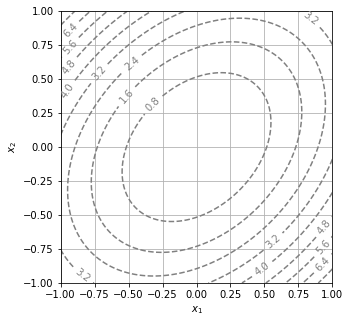

In [87]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [88]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

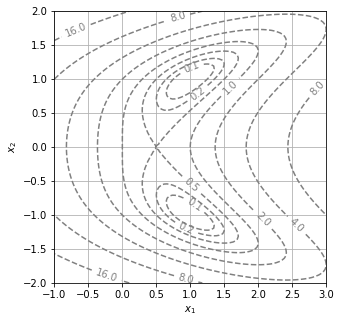

In [89]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [90]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

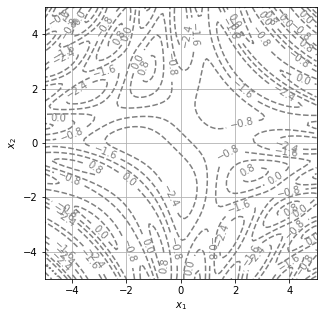

In [91]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [92]:
N = 100
eps = 10**-5

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [93]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_f = J(F)
    for i in range(N):
        
        jaco = J_f(x0,y0)
        jacoinv = np.linalg.inv(jaco)
        x,y = np.array([x0,y0]) - np.dot(jacoinv,F(x0,y0).T).T
        
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [94]:
def newf1(x,y):
    return np.array([f1(x,y)-0.8,x-y])

Newton(newf1, 0.8, 0.8)

(0.4472135954999579, 0.4472135954999579)

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [95]:
def dist(a,b):
    """
    retourne la distance entre les points a et b
    """
    x,y = a
    c,d = b
    return np.sqrt((x-c)**2+(y-d)**2)

def fcercle(f, delta, x0, y0,c):
    """
    On y applique Newton pour etre à delta du point précèdent en restant à la bonne ligne de niveau
    """
    def fc(x,y):
        return np.array([f(x,y)-c,dist((x,y),(x0,y0))-delta])
    return fc

def ortho(vec):
    """
    vecteur orthogonal normalisé à droite
    """
    a,b = vec
    return np.dot(np.array([[0,1],
                           [-1,0]]),vec.T).T/np.sqrt(a*a+b*b)
    
        
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    grad_f = grad(f)
    
    A = np.empty(shape = (2,N))
    A[:,0] = x0,y0
    
    c = f(x0,y0)
    
    for i in range(N-1):
        gradient = grad_f(x0,y0)
        orth = ortho(gradient)*delta
        
        #On va dans la direction à droite du gradient
        x,y = (x0,y0)+orth
        #pour f2 et 0.5, ca bloque au milieu et on peut l'empecher grace à ça; la direction initial reste vers la droite du premier gradient
        if i>=1 and dist(A[:,i-1],(x,y)) < delta*np.sqrt(2):
            x,y = (x0,y0)-orth
            
        fnewt = fcercle(f,delta,x0,y0,c)
        x0,y0 = Newton(fnewt,x,y)
        A[:,i+1] = x0,y0
        
    return A

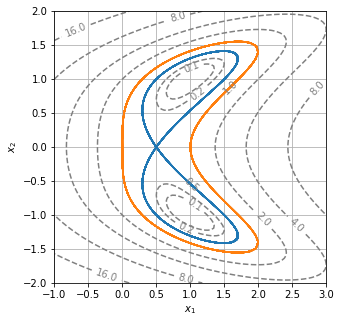

In [96]:
#Pour test la fonction

def newf2(c):
    def f(x,y):
        return( np.array( [ f2(x,y)-c , x-y ]) ) 
    return f

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

x0,y0 = Newton(newf2(0.5),1.0,-0.5)
courbe05 = level_curve(f2,x0,y0)

x0,y0 = Newton(newf2(1),1.0,-0.5)
courbe1 = level_curve(f2,x0,y0)

plt.plot(courbe05[0,:],courbe05[1,:])
plt.plot(courbe1[0,:],courbe1[1,:]);

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [97]:
def level_curve_v2(f, x0, y0, delta=0.1, N=1000, eps=eps):
    grad_f = grad(f)
    
    A = np.empty(shape = (2,N))
    A[:,0] = x0,y0
    
    #Les données initiales nécessaires
    c = f(x0,y0)
    x,y = x0,y0
    grad0 = grad_f(x0,y0)
    
    for i in range(N-1):
        gradient = grad_f(x,y)
        orth = ortho(gradient)*delta
        
        xi,yi = (x,y)+orth
        if i>=1 and dist(A[:,i-1],(xi,yi)) < delta*np.sqrt(2):
            xi,yi = (x,y)-orth
            
        fnewt = fcercle(f,delta,x,y,c)
        x,y = Newton(fnewt,xi,yi)
        A[:,i+1] = x,y

        #On veut verif qu'on est pas proche du début de delta
        if dist((x,y),(x0,y0)) < delta:
            A[0,i+1:] = x0
            A[1,i+1:] = y0
            #print(f"La boucle de niveau {c} a pris {i+1} itérations à être créer.(delta = {delta})")    
            return A
        
    return A

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

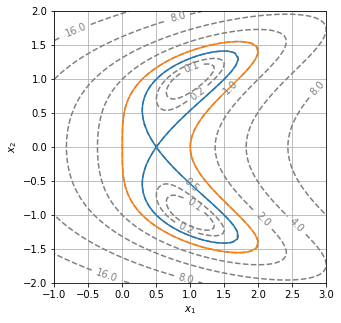

In [98]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

x0,y0 = Newton(newf2(0.5),1.0,-0.5)
courbe05 = level_curve_v2(f2,x0,y0)

x0,y0 = Newton(newf2(1),1.0,-0.5)
courbe1 = level_curve_v2(f2,x0,y0)

plt.plot(courbe05[0,:],courbe05[1,:])
plt.plot(courbe1[0,:],courbe1[1,:]);

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [99]:
def point_depart(f,c,depart,h):
    """
    Retourne un point qui verifie f(z) < c si existe
    """
    
    grad_f = grad(f)
    a,b = depart
    
    N = 0
    while f(a,b) > c and N < 1000:
        a,b = (a,b) - grad_f(a,b)*h
        N += 1
    return (a,b)
        

def entourer(n,z,c,h,f):
    """
    Renvoie le nombre de carré de coté h dans la nième couche verifiant la condition
    """
    
    #Les coordoonées du nième contour
    haut = np.array([ z[0]+(i-n)*h + (n*h+z[1])*1j  for i in range(2*n+1)], dtype = np.cdouble)
    bas = np.array([ z[0]+(i-n)*h + (-n*h+z[1])*1j  for i in range(2*n+1)], dtype = np.cdouble)
    gauche = np.array([ z[0]-n*h + ((i-n)*h+z[1])*1j  for i in range(1,2*n)], dtype = np.cdouble)
    droite = np.array([ z[0]+n*h + ((i-n)*h+z[1])*1j for i in range(1,2*n)], dtype = np.cdouble)
    contour = np.concatenate((haut,bas,gauche,droite))
    
    #Verifie si les points respectent la condition
    def dedans(x):
        if f(x.real,x.imag) <= c:
            return True
        return False
    absolute_vect = np.vectorize(dedans)
    
    return np.sum(absolute_vect(contour))


def area_squares(f,c,h, depart = (0.,0.)):
    """
    depart: point ou l'on commence pour trouver un élement de l'ensemble
    delta: précision pour trouver l'élement
    """
    #On prend une sol de base
    sol = point_depart(f,c,depart,h)
    
    #On l'entoure de carré de plus en plus grand en augmentant les cotés de 2*h jusqu'à entouré la courbe fermée.
    n = 1
    nbcarre = 1
    
    while True:
        nbcarre_rgn = entourer(n,sol,c,h,f)
        nbcarre += nbcarre_rgn
        n += 1
        
        #Si on n'ajoute aucun carré c'est qu'on a entouré la forme et qu'on peut s'arreter
        if nbcarre_rgn == 0:
            return nbcarre*h*h

La liste des erreurs : [1.8584073464102069, 0.10840734641020688, 0.22159265358979274, 0.051592653589792814, 0.01909265358979262, 0.0035926535897927714, 0.0005323464102064968, 0.002079653589793562, 0.001279653589793206, 0.00010734641020704316, 0.0009643464102064847, 0.0006646535897929517, 0.001819653589793191, 0.0004846535897926607, 0.0008676535897933491]


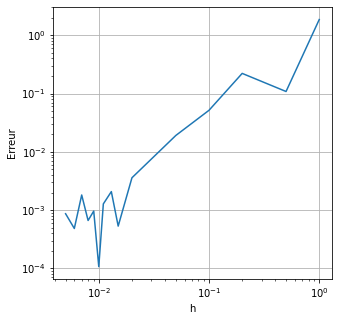

In [103]:
def cercleu(x,y):
    """
    Pour obtenir le cercle unité
    """
    return x**2+y**2


X = [1.0,0.5,0.2,0.1,0.05,0.02,0.015,0.013,0.011,0.01,0.009,0.008,0.007,0.006,0.005]
Y = []
for h in X:
    Y.append(abs(np.pi-area_squares(cercleu,1,h)))

print("La liste des erreurs :", Y)
plt.loglog(X,Y)
plt.grid(True)
plt.xlabel("h") 
plt.ylabel("Erreur");

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [23]:
"""A la place de regarder si le centre des petits carrés sont dedans,
on regarde si un des coin est dedans(pour la majoration)
ou si les quatres sont dedans(pour la minoration).
L'encadrement ne sera pas tout a fait précis car l'ensemble peut faire en sorte de ne toucher aucun coin du carré  en le remplissant par exemple,
ce qui n'est pas le cas pour le cercle;
mais avec un hachurage assez petis cela devrait être réglé."""

def entoure_encadre(n,z,c,h,f):
    """
    Renvoie les nombre de carrés de cotés h dans la nième couche verifiant les conditions
    """
    #Les coordoonées du nième contour
    haut = np.array([ z[0]+(i-n)*h + (n*h+z[1])*1j  for i in range(2*n+1)], dtype = np.cdouble)
    bas = np.array([ z[0]+(i-n)*h + (-n*h+z[1])*1j  for i in range(2*n+1)], dtype = np.cdouble)
    gauche = np.array([ z[0]-n*h + ((i-n)*h+z[1])*1j  for i in range(1,2*n)], dtype = np.cdouble)
    droite = np.array([ z[0]+n*h + ((i-n)*h+z[1])*1j for i in range(1,2*n)], dtype = np.cdouble)
    contour = np.concatenate((haut,bas,gauche,droite))
    
    #Verifie si les points respectent les conditions
    def dedans_inf(x):
        if f(x.real+h/2,x.imag+h/2) < c and f(x.real+h/2,x.imag-h/2) < c and f(x.real-h/2,x.imag+h/2) < c and f(x.real-h/2,x.imag-h/2) < c :
            return True
        return False
    vect_inf = np.vectorize(dedans_inf)
    
    def dedans_sup(x):
        if f(x.real+h/2,x.imag+h/2) < c or f(x.real+h/2,x.imag-h/2) < c or f(x.real-h/2,x.imag+h/2) < c or f(x.real-h/2,x.imag-h/2) < c :
            return True
        return False
    vect_sup = np.vectorize(dedans_sup)
    
    return np.sum(vect_inf(contour)),np.sum(vect_sup(contour))


def area_squares_encadr(f,c,encadr, h=1.0 , depart = (0.0,0.0)):
    #On prend une sol de base
    sol = point_depart(f,c,depart,h)
    
    #On l'entoure de carré de plus en plus grand en augmentant les cotés de 2*h jusqu'à entouré la courbe fermée.
    n = 0
    nbcarre_mino, nbcarre_maj= -1,-1 #A la première itération de entourer on compte deux fois le premier carré central car haut et bas sont confondus
    t = h
    
    while True:
        mino,maj = entoure_encadre(n,sol,c,t,f)
        nbcarre_mino += mino
        nbcarre_maj += maj
        n += 1
        
        #Si on n'ajoute aucun carré c'est qu'on a entouré la forme et qu'on peut s'arreter
        if maj == 0:
            
            if (nbcarre_maj-nbcarre_mino)*t*t < encadr:
                return ( nbcarre_mino*t*t , nbcarre_maj*t*t)
            
            else: #On recommence avec des carrés plus petit car l'encadrement est trop grand
                n = 0
                nbcarre_mino, nbcarre_maj= -1,-1
                t = t/2
                
area_squares_encadr(cercleu,1.0,0.01)

(3.137772560119629, 3.145585060119629)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

La liste des erreurs : [0.14764101192774204, 0.005577558927496895, 0.001338752834314505, 5.244028164241854e-05, 1.3118532416367401e-05, 5.236378579631662e-07]


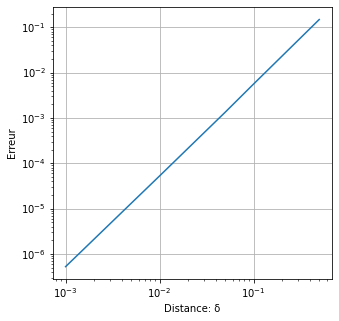

In [104]:
def triang(x1,y1,x2,y2,x3,y3):
    """
    calcul l'aire d'un triangle à l'aide de ses coordonnées
    """
    return 0.5*( x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2) )
triang_vect = np.vectorize(triang)


def cercleu_triang( delta=0.1, N=1000, x0=0., y0=0.):
    """
    Calcule l'aire du cercle unité avec le méthode des triangles
    """
    tab = level_curve_v2(cercleu, 1., 0., delta, N)
    tab_decale = np.roll(tab,1,axis=1)
    
    #Calcul l'aire de tout les triangles
    triangs = triang_vect(tab[0,:],tab[1,:],tab_decale[0,:],tab_decale[1,:],x0,y0)
    
    return abs(np.sum(triangs))



#On test la convergence avec p = (0,0)
Distance = [0.5,0.1,0.05,0.01,0.005,0.001]
Erreur = []
for delta in Distance:
    Erreur.append(abs(np.pi-cercleu_triang(delta,10000)))

print("La liste des erreurs :",Erreur)
plt.loglog(Distance,Erreur)
plt.grid(True)
plt.xlabel('Distance: \u03B4') 
plt.ylabel("Erreur");

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

La liste des erreurs : [0.14764101192774248, 0.005577558927496895, 0.001338752834314505, 5.244028164330672e-05, 1.3118532417699669e-05, 5.23637857519077e-07]


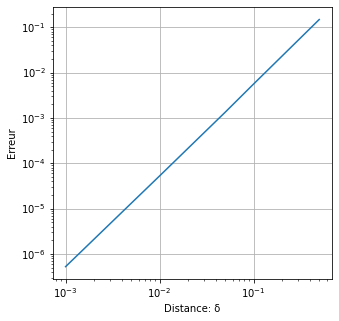

In [105]:
#On test la convergence avec p = (1,1) qui est à l'exterieur
#ça marche car on l'aire en plus est retiré par les triangles n'étant pas dans le même sens
Distance = [0.5,0.1,0.05,0.01,0.005,0.001]
Erreur = []
for delta in Distance:
    Erreur.append(abs(np.pi-cercleu_triang(delta,10000,1.,1.)))

print("La liste des erreurs :",Erreur)
plt.loglog(Distance,Erreur)
plt.grid(True)
plt.xlabel('Distance: \u03B4') 
plt.ylabel("Erreur");

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

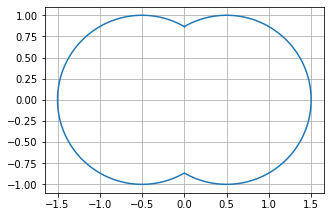

La liste des erreurs : [0.2455497983410364, 0.007651674080250359, 0.001821504334442281, 7.044339467388028e-05, 1.7526753451235777e-05, 6.987287921589314e-07]


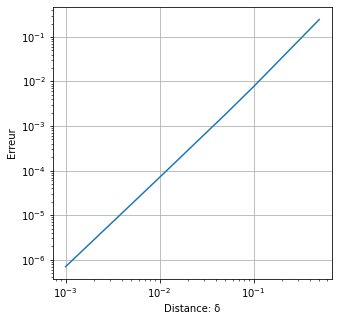

In [106]:
#Les données: p et les delta
x0,y0 = 0.,1.
Distance = [0.5,0.1,0.05,0.01,0.005,0.001]
Erreur = []

for delta in Distance:
    Theta = np.linspace( np.pi/3, np.pi*5/3, int( 4*np.pi/(3*delta) ) )
    X = np.cos(Theta)
    Y = np.sin(Theta)
    
    #La forme: l'union des cercle de rayon et de centre (-0.5,0) et (0.5,0)
    X = np.concatenate((-X+0.5,X-0.5))
    Y = np.concatenate((Y,-Y))

    X_dec = np.roll(X,1)
    Y_dec = np.roll(Y,1)
    
    triangs = triang_vect(X,Y,X_dec,Y_dec,x0,y0)
    aire = abs(np.sum(triangs))
    Erreur.append(abs( 4*np.pi/3+np.sqrt(3)/2 - aire ))
    
    
#On montre la forme
plt.plot(X,Y)
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()


#Le graphe de l'erreur en fonction de delta
print("La liste des erreurs :",Erreur)
plt.loglog(Distance,Erreur)
plt.grid(True)
plt.xlabel('Distance: \u03B4') 
plt.ylabel("Erreur");

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [107]:
def area_triangles(x,y,x0=0.,y0=0.):
    x_dec = np.roll(x,1)
    y_dec = np.roll(y,1)
    
    triangs = triang_vect(x,y,x_dec,y_dec,x0,y0)
    return abs(np.sum(triangs))

In [109]:
x0,y0 = Newton(newf2(1),1.0,-0.5)
courbe1 = level_curve_v2(f2,x0,y0)

#aire de f2(x,y) < 1 avec delta = 1
print(f"méthode des triangles : {area_triangles(courbe1[0,:],courbe1[1,:])}")
print(f"méthode des carrés : {area_squares(f2,1.0,0.1)}")

#Les deux méthodes ont l'air cohérente

méthode des triangles : 3.6673621943104826
méthode des carrés : 3.69


In [ ]:
"""La méthode des triangles converge plus rapidement lorsqu'on a une courbe de niveau.(notamment pour l'aire d'un cercle)
Cependant la méthode des carrés n'a pas besoin de courbe de niveau."""